# Predicting TCR–Neoantigen Binding with ML models (Isolation Forest and XGBoost)

#### Import Libraries

In [ ]:
import os
import scanpy as sc
import scipy.io
import scipy.sparse as sp
import pandas as pd 
import numpy as np
import anndata
import matplotlib.pyplot as plt
import seaborn as sns


#### Set directory variables for the samples

In [400]:
def set_directories(patient_id, base_dir):
    """
    Generate a dictionary containing paths to relevant directories for a given patient.
    
    Parameters:
    - patient_id (str): The unique identifier for the patient.
    - base_dir (str): The base directory containing all patient data.
    
    Returns:
    - dict: A dictionary with paths to gene expression, dextramer, TCR, and CITE-seq data.
    """
    return {
        "dir_gex": os.path.join(base_dir, f"{patient_id}/CellRangerGex_results"),
        "dir_dex": os.path.join(base_dir, f"{patient_id}_dextramer_count/umi_count"),
        "dir_TCR": os.path.join(base_dir, f"{patient_id}_TCR_VDJ/CellRangerVdj_results"),
        "dir_CITE": os.path.join(base_dir, f"{patient_id}_hash_count/umi_count")
    }

# Define base directory and patient IDs
base_dir = "/Users/ecrosse/Desktop/"

# Set directories for each patient
dirs_SRSF2_9 = set_directories("data_for_edie_third_batch_january/WJK-2859_SRSF2_9", base_dir)
dirs_SRSF2_10 = set_directories("dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10", base_dir)

# Print to verify the directory structure
print(dirs_SRSF2_9)
print(dirs_SRSF2_10)


{'dir_gex': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9/CellRangerGex_results', 'dir_dex': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_dextramer_count/umi_count', 'dir_TCR': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_TCR_VDJ/CellRangerVdj_results', 'dir_CITE': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_hash_count/umi_count'}
{'dir_gex': '/Users/ecrosse/Desktop/dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10/CellRangerGex_results', 'dir_dex': '/Users/ecrosse/Desktop/dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10_dextramer_count/umi_count', 'dir_TCR': '/Users/ecrosse/Desktop/dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10_TCR_VDJ/CellRangerVdj_results', 'dir_CITE': '/Users/ecrosse/Desktop/dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10_hash_count/umi_count'}


## Prepare adata with integrated gene expression, dextramer, CITE-Seq and TCR sequence data
Load gene expression into adata

In [401]:
# Define paths
dir_gex = dirs_SRSF2_9["dir_gex"]
dir_dex = dirs_SRSF2_9["dir_dex"]
dir_CITE = dirs_SRSF2_9["dir_CITE"]

print(dir_gex)
print(dir_dex)
print(dir_CITE)

adata = sc.read_10x_h5(os.path.join(dir_gex, "filtered_feature_bc_matrix.h5"))
adata.var_names_make_unique()
adata

/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9/CellRangerGex_results
/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_dextramer_count/umi_count
/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_hash_count/umi_count


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 8008 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

Load CITE and Dextramer data

In [402]:
# Load CITE-seq data
cite_matrix = scipy.io.mmread(f"{dir_CITE}/matrix.mtx.gz").T.tocsr()
cite_barcodes = pd.read_csv(f"{dir_CITE}/barcodes.tsv.gz", header=None, sep='\t')[0].values + "-1"
cite_features = pd.read_csv(f"{dir_CITE}/features.tsv.gz", header=None, sep='\t')[1].values

# Load Dextramer data
dex_matrix = scipy.io.mmread(f"{dir_dex}/matrix.mtx.gz").T.tocsr()
dex_barcodes = pd.read_csv(f"{dir_dex}/barcodes.tsv.gz", header=None, sep='\t')[0].values + "-1"
dex_features = pd.read_csv(f"{dir_dex}/features.tsv.gz", header=None, sep='\t')[1].values

# Find common barcodes across all datasets
common_barcodes = list(set(adata.obs_names) & set(cite_barcodes) & set(dex_barcodes))

# Subset adata to common barcodes
adata = adata[adata.obs_names.isin(common_barcodes)].copy()

# Ensure barcodes are in the same order
cite_indices = np.array([np.where(cite_barcodes == bc)[0][0] for bc in adata.obs_names])
dex_indices = np.array([np.where(dex_barcodes == bc)[0][0] for bc in adata.obs_names])

cite_matrix = cite_matrix[cite_indices, :]
dex_matrix = dex_matrix[dex_indices, :]

# Store multimodal data in .obsm
adata.obsm["CITE"] = cite_matrix
adata.obsm["Dextramer"] = dex_matrix

# Store feature names in .uns
adata.uns["CITE_features"] = cite_features
adata.uns["Dextramer_features"] = dex_features

print("CITE-seq and Dextramer data successfully added to anndata.")



CITE-seq and Dextramer data successfully added to anndata.


Write raw adata

In [403]:
adata.write("adata_raw.h5ad")

QC steps

In [404]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [405]:
print(adata.obs.describe())

       n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt
count        7992.000000   7992.000000      7992.000000    7992.000000
mean         1840.969094   4664.024902        42.327953       1.058015
std           688.167250   2522.644531        40.968998       1.335171
min            40.000000    500.000000         0.000000       0.000000
25%          1481.000000   3430.000000        11.000000       0.309042
50%          1794.000000   4375.000000        36.000000       0.857646
75%          2104.250000   5321.250000        61.000000       1.360179
max          6367.000000  30498.000000       752.000000      27.407408


In [ ]:
sc.pp.filter_cells(adata, min_genes=250)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_counts=500)
# Saving count data
adata.layers["counts"] = adata.X.copy()

# Normalize data (log1p normalization)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=4000)

# Filter out genes starting with "TR"
variable_genes = adata.var["highly_variable"]
filtered_variable_genes = adata.var_names[variable_genes & ~adata.var_names.str.startswith("TR")]
# Update the list of highly variable genes
adata.var["highly_variable"] = adata.var_names.isin(filtered_variable_genes)

# Scale the data
sc.pp.scale(adata, max_value=10)  # Scale all genes

VDJ sequence / clonotype info integration into adata

In [ ]:
# set TCR dir
dir_TCR = dirs_SRSF2_9["dir_TCR"]


# Load V(D)J data
vdj = pd.read_csv(f"{dir_TCR}/filtered_contig_annotations.csv")

# Filtering steps
tcr = vdj[
    (vdj["high_confidence"] == True) & 
    (vdj["chain"].isin(["TRA", "TRB"])) & 
    (vdj["productive"] == True) & 
    (vdj["umis"] >= 3)
][["barcode", "chain", "raw_clonotype_id", 
   "v_gene", "d_gene", "j_gene", "c_gene", 
   "cdr1_nt", "cdr2_nt", "cdr3_nt"]]

# Group by raw_clonotype_id and filter for entries that contain both TRA and TRB chains
tcr = tcr.groupby("raw_clonotype_id").filter(lambda g: any(g["chain"] == "TRA") and any(g["chain"] == "TRB"))

# Reset index if needed
tcr = tcr.reset_index(drop=True)

# Print summary
print(tcr.head())

# Load clonotype data
clono = pd.read_csv(f"{dir_TCR}/clonotypes.csv")

# Select and rename columns
clono = clono[["clonotype_id", "cdr3s_aa", "cdr3s_nt"]].rename(columns={"clonotype_id": "raw_clonotype_id"})

# Perform a left join with tcr on "raw_clonotype_id"
tcr = tcr.merge(clono, on="raw_clonotype_id", how="left")

# Select barcode and raw_clonotype_id
clonotype_info = tcr[["barcode", "raw_clonotype_id"]].drop_duplicates(subset=["barcode"])

# Set barcode as row index and drop barcode column
clonotype_info = clonotype_info.set_index("barcode")

# Print the resulting dataframe
print(clonotype_info.head())

# Add tcr to metadata
adata.obs = adata.obs.join(clonotype_info, how="left")

# Check if the metadata was added
print(adata.obs.head())

              barcode chain raw_clonotype_id    v_gene d_gene   j_gene c_gene  \
0  AAACCTGAGCCAGTAG-1   TRA     clonotype332   TRAV1-2    NaN   TRAJ12   TRAC   
1  AAACCTGAGCCAGTAG-1   TRB     clonotype332   TRBV6-1  TRBD2  TRBJ2-1  TRBC2   
2  AAACCTGAGGAGTTGC-1   TRA    clonotype1183  TRAV26-2    NaN   TRAJ49   TRAC   
3  AAACCTGAGGAGTTGC-1   TRB    clonotype1183    TRBV19  TRBD1  TRBJ2-7  TRBC2   
4  AAACCTGAGTACGACG-1   TRB       clonotype5    TRBV28    NaN  TRBJ1-1  TRBC1   

                 cdr1_nt             cdr2_nt  \
0     ACATCTGGGTTCAACGGG  AATGTTCTGGATGGTTTG   
1        ATGAACCATAACTCC  TCAGCTTCTGAGGGTACC   
2  ACAATCAGTGGAACTGATTAC     GGTCTTACAAGCAAT   
3        TTGAACCACGATGCC  TCACAGATAGTAAATGAC   
4        ATGGACCATGAAAAT  TCATATGATGTTAAAATG   

                                         cdr3_nt  
0           TGTGCTGGGATGGATAGCAGCTATAAATTGATCTTC  
1  TGTGCCAGCAGTGAACTAGCGGGAGGGTACAATGAGCAGTTCTTC  
2           TGCATCCTGAGAGACTCGGATAACCAGTTCTATTTT  
3  TGTGCCAGTAGCGACAC

CITE-Seq Dex+ cell determination - CITE-Seq hashing antibody represents Dextramer - population

In [ ]:
def clr_transform(matrix, eps=1e-9):
    """Applies CLR transformation to an input matrix (cell-wise), optimized for sparse matrices."""
    if sp.issparse(matrix):
        matrix = matrix.toarray()  # Convert sparse matrix to dense (if memory allows)
    
    gm = np.exp(np.mean(np.log(matrix + eps), axis=1, keepdims=True))  # Geometric mean per cell
    return np.log((matrix + eps) / (gm + eps))  # Standard CLR transformation

# Apply CLR to CITE-seq data
adata.obsm["CITE_clr"] = clr_transform(adata.obsm["CITE"])


# Identify the index of the "Hash" column
hash_col_index = np.where(adata.uns["CITE_features"] == "Hash")[0][0]

# Extract the Hash column
hash_values = adata.obsm["CITE_clr"][:, hash_col_index]

# Plot density histogram
plt.figure(figsize=(7, 5))
sns.histplot(hash_values, kde=True, bins=50)

plt.xlabel("CLR-transformed Hash expression")
plt.ylabel("Density")
plt.title("Histogram Density Plot of CITE_clr Hash Column")
plt.show()

Using the generated plot manually set the threshold cut off hashed counts (more reliable to do it manually)

In [ ]:
# Extract the Hash column from CITE_clr
hash_counts = adata.obsm["CITE_clr"][:, hash_col_index]

# Store the extracted counts in adata.obs
adata.obs["HashCounts"] = hash_counts
# Create 'manual_hash_dmux' based on HashCounts threshold
adata.obs["manual_hash_dmux"] = np.where(adata.obs["HashCounts"] > 0.8, "CITE_hash", "Negative")
adata.obs["manual_hash_dmux"].value_counts()


Remove unmapped dextramer features from dex expression matrix

In [ ]:
# Identify index of "Unmapped"
unmapped_idx = np.where(adata.uns["Dextramer_features"] == "unmapped")[0][0]

# Remove "Unmapped" from feature list
adata.uns["Dextramer_features"] = np.delete(adata.uns["Dextramer_features"], unmapped_idx)

# Remove "Unmapped" from the Dextramer matrix
adata.obsm["Dextramer"] = sp.csr_matrix(np.delete(adata.obsm["Dextramer"].toarray(), unmapped_idx, axis=1))

# Sum total dextramer counts per cell and store in .obs
adata.obs["Dextramer_total_counts"] = adata.obsm["Dextramer"].sum(axis=1)

# Verify the new column
print(adata.obs["Dextramer_total_counts"].head())


Check that Dextramer read counts are higher in Dex+ population afer CITE hashing dmux

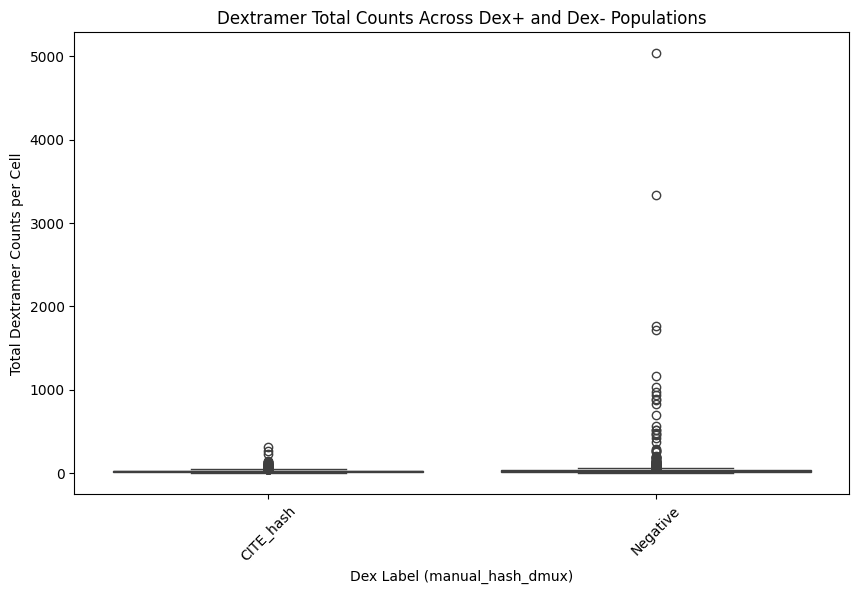

In [418]:
# Create a boxplot of Dextramer total counts grouped by manual_hash_dmux categories
plt.figure(figsize=(10, 6))
sns.boxplot(data=adata.obs, x="manual_hash_dmux", y="Dextramer_total_counts")

# Customize plot labels and title
plt.xlabel("Dex Label (manual_hash_dmux)")
plt.ylabel("Total Dextramer Counts per Cell")
plt.title("Dextramer Total Counts Across Dex+ and Dex- Populations")

# Rotate x-axis labels if necessary for readability
plt.xticks(rotation=45)

plt.show()


Check out distribution of reads across dextramers to identify outliers e.g. SRSF2-18

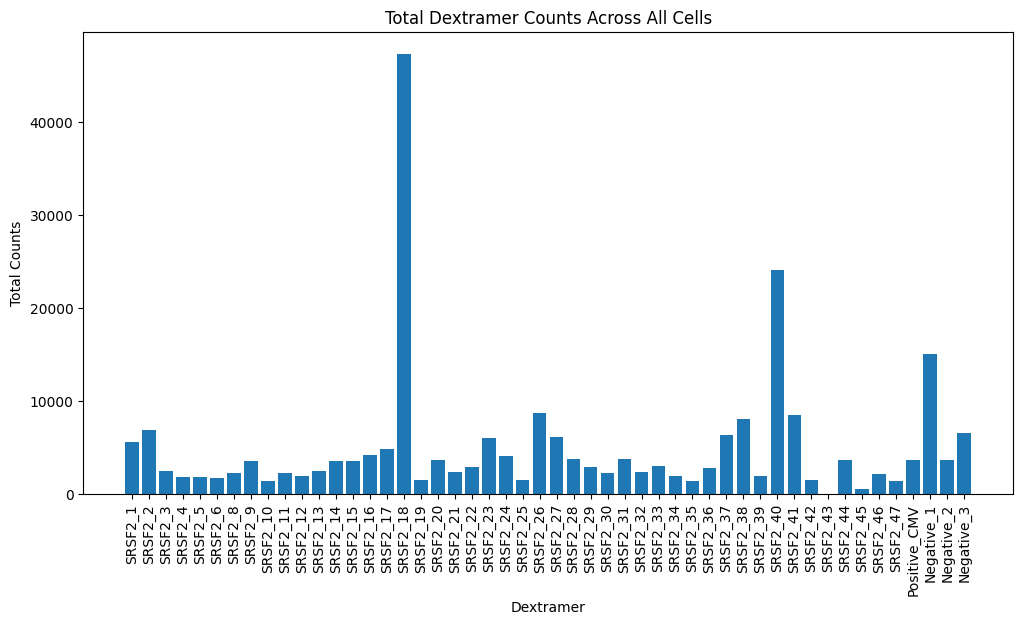

In [419]:
# Sum counts per dextramer across all cells
dextramer_counts = np.array(adata.obsm["Dextramer"].sum(axis=0)).flatten()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(adata.uns["Dextramer_features"], dextramer_counts)
plt.xticks(rotation=90)
plt.xlabel("Dextramer")
plt.ylabel("Total Counts")
plt.title("Total Dextramer Counts Across All Cells")
plt.show()

### Feature Engineering - Start Building the Feature Set for ML Pipelines

Different features, once calculated, will be stored in adata

##### 1. Normalized dextramer signal (Dextramer_norm)

Find the fold change for each cell of the dextramer signal compared to the mean in the Dex-

In [ ]:
# Extract dextramer matrix as dense array
dex_matrix = adata.obsm["Dextramer"].toarray()

# Extract Dex+ and Dex- labels
dex_labels = adata.obs["manual_hash_dmux"]

# Identify Dex- cells 
dex_neg_cells = dex_labels == "CITE_hash"  

# Compute the mean background signal for each dextramer using only Dex- cells
dex_background = dex_matrix[dex_neg_cells].mean(axis=0)  

# Normalize dextramer signals by their background (Fold-Change Enrichment)
dex_fold_change = dex_matrix / dex_background

# Apply log transformation to reduce extreme values 
dex_log_fc = np.log1p(dex_fold_change)  # log(1 + x) transformation

# Store the background-normalized dextramer signals back in adata
adata.obsm["Dextramer_norm"] = dex_log_fc

# Print sanity check
print("Shape of normalized dextramer matrix:", adata.obsm["Dextramer_norm"].shape)
print("First few values of a random dextramer after normalization:\n", dex_log_fc[:, 0][:5])

Shape of normalized dextramer matrix: (7991, 50)
First few values of a random dextramer after normalization:
 [0. 0. 0. 0. 0.]


Plot some normalized dextramers

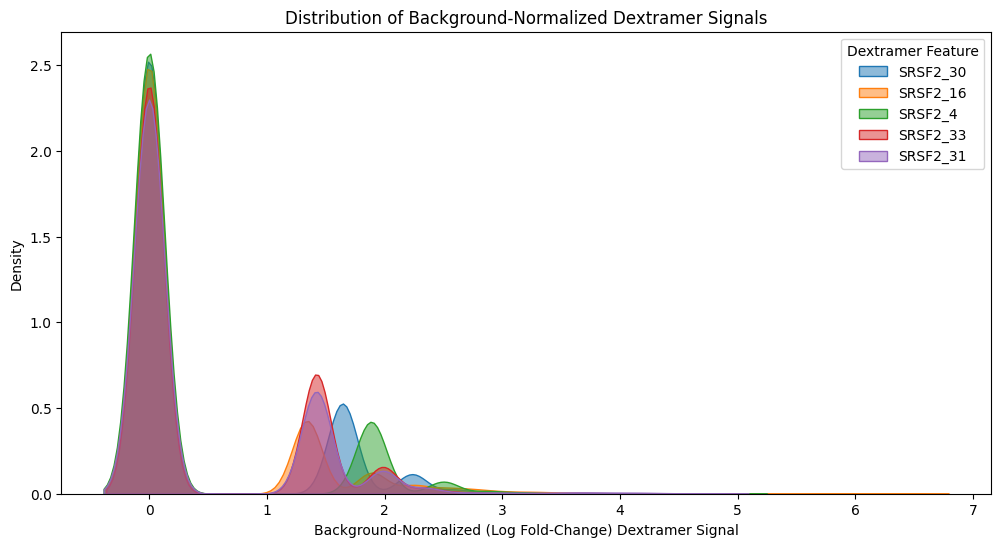

In [425]:
# Select a few dextramers to visualize (randomly choosing 5 for now)
num_features = adata.obsm["Dextramer_norm"].shape[1]
selected_dextramers = np.random.choice(num_features, size=5, replace=False)

# Convert the selected dextramers into a DataFrame for easier plotting
dex_norm_df = pd.DataFrame(adata.obsm["Dextramer_norm"][:, selected_dextramers],
                           columns=[adata.uns["Dextramer_features"][i] for i in selected_dextramers])

# Plot the density distribution of the selected dextramer signals
plt.figure(figsize=(12, 6))
for col in dex_norm_df.columns:
    sns.kdeplot(dex_norm_df[col], label=col, fill=True, alpha=0.5)

plt.xlabel("Background-Normalized (Log Fold-Change) Dextramer Signal")
plt.ylabel("Density")
plt.title("Distribution of Background-Normalized Dextramer Signals")
plt.legend(title="Dextramer Feature")
plt.show()

##### 2. Relative enrichment score (Dextramer_enrichment)

Relative enrichment score of a dextramer per cell compared to the mean of the Dex+ population.

In [429]:
# Identify Dex+ cells
dex_pos_cells = dex_labels != "CITE_hash" 

# Compute mean dextramer signal across Dex+ cells (per dextramer)
dex_mean_pos = dex_matrix[dex_pos_cells].mean(axis=0)  # Mean per dextramer in Dex+ cells

# Compute relative enrichment: deviation from Dex+ mean (per dextramer, per cell)
dex_enrichment = dex_matrix - dex_mean_pos  # Element-wise subtraction

# Store in adata
adata.obsm["Dextramer_enrichment"] = dex_enrichment

# Print sanity check
print("Shape of Dex+ enrichment matrix:", adata.obsm["Dextramer_enrichment"].shape)
print("First few values of a random dextramer after enrichment calculation:\n", dex_enrichment[:, 0][:5])

Shape of Dex+ enrichment matrix: (7991, 50)
First few values of a random dextramer after enrichment calculation:
 [-1.34340079 -1.34340079 -1.34340079 -1.34340079 -1.34340079]


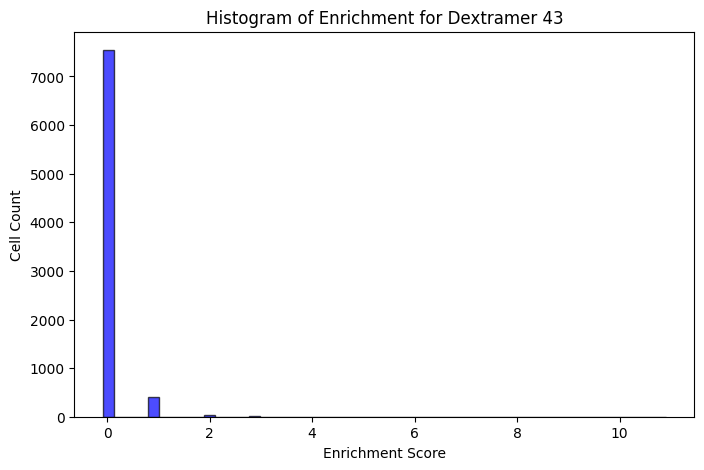

In [ ]:
# Select a dextramer
dex_idx = 43  # Change this to visualize a different dextramer
dex_values = adata.obsm["Dextramer_enrichment"][:, dex_idx]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(dex_values, bins=50, alpha=0.7, color='b', edgecolor='k')
plt.xlabel("Enrichment Score")
plt.ylabel("Cell Count")
plt.title(f"Histogram of Enrichment for Dextramer {dex_idx}")
plt.show()

##### 3. Dex+ population enriched clonotypes (clonotype_enrichment)

Identify enriched clonotypes within Dex+ cells

In [ ]:
# Extract TCR clonotype IDs and Dex+/- labels
clonotypes = adata.obs["raw_clonotype_id"]
dex_labels = adata.obs["manual_hash_dmux"]

# Identify Dex+ and Dex- cells based on corrected labels
dex_pos_mask = dex_labels == "Negative"  # Dex+ group
dex_neg_mask = dex_labels == "CITE_hash"  # Dex- group

# Compute total number of cells in each group
total_dex_pos = np.sum(dex_pos_mask)
total_dex_neg = np.sum(dex_neg_mask)

# Count occurrences of each clonotype in Dex+ and Dex- cells
clonotype_counts = pd.DataFrame({
    "Dex+ Count": clonotypes[dex_pos_mask].value_counts(),
    "Dex- Count": clonotypes[dex_neg_mask].value_counts()
}).fillna(0)


# Compute frequency (proportion) in each group
clonotype_counts["Dex+ Frequency"] = clonotype_counts["Dex+ Count"] / total_dex_pos
clonotype_counts["Dex- Frequency"] = clonotype_counts["Dex- Count"] / total_dex_neg

# Compute fold-change enrichment (log-scaled for better interpretability)
clonotype_counts["Enrichment Ratio"] = clonotype_counts["Dex+ Frequency"] / (clonotype_counts["Dex- Frequency"] + 1e-6)
clonotype_counts["Log Enrichment"] = np.log2(clonotype_counts["Enrichment Ratio"] + 1e-6)


# Store results in adata for later use
adata.uns["clonotype_enrichment"] = clonotype_counts

# Print top TCR clonotypes with highest enrichment
print("Top 10 TCR clonotypes enriched in Dex+ cells:")
print(clonotype_counts.sort_values(by="Dex+ Frequency", ascending=False).head(10))


##### 4. Dextramer rank per cell. 5. Dextramer competition per cell

Dextramer rankings and Dextramer competition score (ie. the margin between top dextramers per cell)

In [ ]:
# Use normalized dextramer data
dex_matrix_norm = adata.obsm["Dextramer_norm"]

# Compute ranks within each cell
dextramer_ranks = np.argsort(-dex_matrix_norm, axis=1)  # Descending order
dextramer_rank_values = np.argsort(dextramer_ranks, axis=1) + 1  # Convert to rank (1 = highest)

# Compute competition score
sorted_dex_values = np.sort(dex_matrix_norm, axis=1)[:, ::-1]  # Sort values descending
top_dextramer_signal = sorted_dex_values[:, 0]  # Strongest dextramer per cell
second_strongest_signal = sorted_dex_values[:, 1]  # Second strongest dextramer per cell

top_dextramer_margin = (top_dextramer_signal - second_strongest_signal) / (top_dextramer_signal + 1e-6)

# Store in adata for ML use later
adata.obsm["Dextramer_rank"] = dextramer_rank_values  # Rank matrix per cell/dextramer
adata.obs["Top_dextramer_margin"] = top_dextramer_margin  # One value per cell


##### Build the Feature Matrix `X`

This section extracts and compiles all engineered features from the `AnnData` object (`adata`) into a unified DataFrame called `X`. This matrix serves as the input for the machine learning pipelines (XGBoost and Isolation Forest). Each row represents a `(cell, dextramer)` pair with features describing signal strength, clonotype context, and enrichment characteristics.

First get dextramer features:

In [ ]:
# Extract Cell-Level Features from `obs`
cell_features = adata.obs[["raw_clonotype_id", "Top_dextramer_margin"]].copy()

# Compute clonotype count as an additional feature
clonotype_counts = adata.obs["raw_clonotype_id"].value_counts().to_dict()
cell_features["clonotype_count"] = cell_features["raw_clonotype_id"].map(clonotype_counts)  

# Extract Dextramer-Level Features from `obsm`
dex_norm_df = pd.DataFrame(adata.obsm["Dextramer_norm"], index=adata.obs_names)
dex_rank_df = pd.DataFrame(adata.obsm["Dextramer_rank"], index=adata.obs_names)
dex_enrich_df = pd.DataFrame(adata.obsm["Dextramer_enrichment"], index=adata.obs_names)  

# Melt the data to create a (cell, dextramer) pair structure
dex_norm_melted = dex_norm_df.reset_index().melt(id_vars="index", var_name="dextramer", value_name="dex_norm")
dex_rank_melted = dex_rank_df.reset_index().melt(id_vars="index", var_name="dextramer", value_name="dex_rank")
dex_enrich_melted = dex_enrich_df.reset_index().melt(id_vars="index", var_name="dextramer", value_name="dex_enrich")  

# Merge all dextramer-related features
dex_features = dex_norm_melted.merge(dex_rank_melted, on=["index", "dextramer"]).merge(dex_enrich_melted, on=["index", "dextramer"])  

# Merge with Cell-Level Features (now includes clonotype count)
X = pd.merge(dex_features, cell_features, left_on="index", right_index=True)

# Rename index for clarity
X.rename(columns={"index": "cell_id"}, inplace=True)


Matrix tidying

In [ ]:
# Fill missing clonotype IDs with "Unknown"
X["raw_clonotype_id"] = X["raw_clonotype_id"].fillna("_no_clonotype_")

# Fill missing clonotype counts with 0
X["clonotype_count"] = X["clonotype_count"].fillna(0)

# Rename dextramer indices with their feature names
dextramer_names = list(adata.uns["Dextramer_features"])  

# Create mapping from index to name
dex_index_to_name = {i: name for i, name in enumerate(dextramer_names)}

# Print a few mappings to verify
print("Example dextramer mapping:", list(dex_index_to_name.items())[:10])

# Apply mapping
X["dextramer"] = X["dextramer"].map(dex_index_to_name)

Example dextramer mapping: [(0, 'SRSF2_1'), (1, 'SRSF2_2'), (2, 'SRSF2_3'), (3, 'SRSF2_4'), (4, 'SRSF2_5'), (5, 'SRSF2_6'), (6, 'SRSF2_8'), (7, 'SRSF2_9'), (8, 'SRSF2_10'), (9, 'SRSF2_11')]


Add clonotype enrichment to X

In [ ]:
# Convert stored enrichment DataFrame from adata.uns
clono_enrich_df = adata.uns["clonotype_enrichment"]

# Just keep the 'Log Enrichment' column 
clono_enrich_df = clono_enrich_df[["Log Enrichment"]]

# Merge into your X DataFrame by raw_clonotype_id
X = X.merge(clono_enrich_df, left_on="raw_clonotype_id", right_index=True, how="left")

# Rename for consistency
X.rename(columns={"Log Enrichment": "clonotype_enrichment"}, inplace=True)

# Fill missing enrichment values with 0
X["clonotype_enrichment"] = X["clonotype_enrichment"].fillna(0)

# Sanity check
print(X[["raw_clonotype_id", "clonotype_enrichment"]].head())

,cell_id,dextramer,dex_norm,dex_rank,dex_enrich,raw_clonotype_id,Top_dextramer_margin,clonotype_count,Log Enrichment
0,AAACCTGAGAGACTAT-1,SRSF2_1,0.000000,15,-1.343401,_no_clonotype_,0.029817,0.0,NaN
7991,AAACCTGAGAGACTAT-1,SRSF2_2,0.000000,29,-1.691634,_no_clonotype_,0.029817,0.0,NaN
15982,AAACCTGAGAGACTAT-1,SRSF2_3,0.000000,30,-0.380248,_no_clonotype_,0.029817,0.0,NaN
23973,AAACCTGAGAGACTAT-1,SRSF2_4,0.000000,31,-0.294171,_no_clonotype_,0.029817,0.0,NaN
31964,AAACCTGAGAGACTAT-1,SRSF2_5,0.000000,32,-0.288432,_no_clonotype_,0.029817,0.0,NaN
...,...,...,...,...,...,...,...,...,...
367585,TTTGTCATCATAAAGG-1,SRSF2_47,0.000000,20,-0.257928,clonotype3,0.231058,259.0,-0.741801
375576,TTTGTCATCATAAAGG-1,Positive_CMV,0.000000,15,-0.514648,clonotype3,0.231058,259.0,-0.741801
383567,TTTGTCATCATAAAGG-1,Negative_1,0.000000,11,-2.037451,clonotype3,0.231058,259.0,-0.741801
391558,TTTGTCATCATAAAGG-1,Negative_2,0.000000,27,-0.548475,clonotype3,0.231058,259.0,-0.741801


Check X is looking as expected

In [ ]:
X

,cell_id,dextramer,dex_norm,dex_rank,dex_enrich,raw_clonotype_id,Top_dextramer_margin,clonotype_count,clonotype_enrichment
0,AAACCTGAGAGACTAT-1,SRSF2_1,0.000000,15,-1.343401,_no_clonotype_,0.029817,0.0,0.000000
7991,AAACCTGAGAGACTAT-1,SRSF2_2,0.000000,29,-1.691634,_no_clonotype_,0.029817,0.0,0.000000
15982,AAACCTGAGAGACTAT-1,SRSF2_3,0.000000,30,-0.380248,_no_clonotype_,0.029817,0.0,0.000000
23973,AAACCTGAGAGACTAT-1,SRSF2_4,0.000000,31,-0.294171,_no_clonotype_,0.029817,0.0,0.000000
31964,AAACCTGAGAGACTAT-1,SRSF2_5,0.000000,32,-0.288432,_no_clonotype_,0.029817,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
367585,TTTGTCATCATAAAGG-1,SRSF2_47,0.000000,20,-0.257928,clonotype3,0.231058,259.0,-0.741801
375576,TTTGTCATCATAAAGG-1,Positive_CMV,0.000000,15,-0.514648,clonotype3,0.231058,259.0,-0.741801
383567,TTTGTCATCATAAAGG-1,Negative_1,0.000000,11,-2.037451,clonotype3,0.231058,259.0,-0.741801
391558,TTTGTCATCATAAAGG-1,Negative_2,0.000000,27,-0.548475,clonotype3,0.231058,259.0,-0.741801


(Code to incorporate partial ground truth - for Random Forests only so obsolete)

In [ ]:
# # Manually define the known true binder
# known_true_pairs = [("clonotype16", "SRSF2_31")]

# # Initialize y as all zeros (assume non-binder by default)
# y = pd.Series(0, index=X.index)

# # Set y = 1 for known true binders
# y.loc[X[["raw_clonotype_id", "dextramer"]].apply(tuple, axis=1).isin(known_true_pairs)] = 1

# print("Label distribution:\n", y.value_counts())


Label distribution:
 0    399493
1        57
Name: count, dtype: int64


In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report

# # Define features (excluding non-numeric columns)
# feature_cols = [
#     "dex_norm",
#     "dex_rank",
#     "dex_enrich",
#     "Top_dextramer_margin",
#     "clonotype_count",
#     "clonotype_enrichment"  # <- new feature!
# ]

# X_model = X[feature_cols]  # Feature matrix
# y_model = y  # Target variable

# # Split into training (80%) and test (20%)
# X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42, stratify=y)

# # Train Random Forest
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
# rf_model.fit(X_train, y_train)

# # Predict on test set
# y_pred = rf_model.predict(X_test)

# # Evaluate performance
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print(f"Model Accuracy: {accuracy:.4f}")
# print("Classification Report:\n", report)


Model Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     79899
           1       1.00      0.91      0.95        11

    accuracy                           1.00     79910
   macro avg       1.00      0.95      0.98     79910
weighted avg       1.00      1.00      1.00     79910



In [ ]:
# print(X.columns)  # Look for 'clonotype_enrichment'
# print(X["clonotype_enrichment"].describe())  # Sanity check values


Index(['cell_id', 'dextramer', 'dex_norm', 'dex_rank', 'dex_enrich',
       'raw_clonotype_id', 'Top_dextramer_margin', 'clonotype_count',
       'clonotype_enrichment'],
      dtype='object')
count    399550.000000
mean         -1.079862
std           5.505596
min         -19.931569
25%          -0.741801
50%           0.000000
75%           0.000000
max          10.560445
Name: clonotype_enrichment, dtype: float64


#### ML model 1 - Isolation forest model

This works well if there are expected to be very few true binders (which is what we found with our data). It requires no supervision and detects 'anomalies' in the patterns which are actually expected to be true binders.

First we train the model

In [ ]:
from sklearn.ensemble import IsolationForest

# Define Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)  # 0.1% expected outliers

# Fit the model on scaled data
iso_forest.fit(X_scaled)

# Predict anomaly scores (-1 = outlier, 1 = inlier)
X["binding_anomaly_score"] = iso_forest.decision_function(X_scaled)  # Higher = more normal, lower = more anomalous
X["is_likely_binder"] = iso_forest.predict(X_scaled)  # -1 means likely binder, 1 means normal background

print("Isolation Forest model trained ✅")

Isolation Forest model trained ✅


Examine the output by grouping by dextramer / clonotype

In [551]:
# Group by (dextramer, clonotype)
X_grouped = X.groupby(["dextramer", "raw_clonotype_id"]).agg(
    mean_score=("binding_anomaly_score", "mean"),  # Average anomaly score
    min_score=("binding_anomaly_score", "min"),    # Best anomaly score
    count=("binding_anomaly_score", "count")       # How often this pair appears
).reset_index()

# Compute a final ranking score (higher weight for best anomaly score, adjusted by count)
X_grouped["final_score"] = X_grouped["min_score"] * 0.7 + X_grouped["mean_score"] * 0.3

# Rank by final score (lower = better binder)
X_ranked = X_grouped.sort_values(by="final_score")

# Display top predicted unique binding pairs
print("Top predicted unique neoantigen-TCR binding pairs:\n", X_ranked.head(50))


Top predicted unique neoantigen-TCR binding pairs:
           dextramer raw_clonotype_id  mean_score  min_score  count  \
16257       SRSF2_2     clonotype558   -0.052128  -0.052128      1   
29228      SRSF2_31      clonotype16    0.011904  -0.051390     57   
5303       SRSF2_10    clonotype1249   -0.027695  -0.027695      1   
29148      SRSF2_31    clonotype1467   -0.023375  -0.023375      1   
22918      SRSF2_26    clonotype1353   -0.023274  -0.023274      1   
39179      SRSF2_40       clonotype1    0.079725  -0.054834    506   
24707      SRSF2_27     clonotype950   -0.014346  -0.014346      1   
11342      SRSF2_16       clonotype1    0.123325  -0.068761    506   
21614      SRSF2_24     clonotype950   -0.009393  -0.009393      1   
13404      SRSF2_18       clonotype1    0.061151  -0.038849    506   
22683      SRSF2_26       clonotype1    0.102906  -0.055124    506   
17490      SRSF2_20     clonotype950   -0.006593  -0.006593      1   
13724      SRSF2_18    clonotype1519  

##### ML model 2 - XGBoost

This requires a partial ground truth for which we use the normalized dextramer count per cell. 

In [553]:
from xgboost import XGBRegressor

# Feature set
feature_cols = ["dex_rank", "dex_enrich", "Top_dextramer_margin", "clonotype_count", "clonotype_enrichment"]
X_model = X[feature_cols]

# Target = normalized dextramer signal (assumed indicative of binding strength)
y_model = X["dex_norm"]


In [554]:
# Initialize and train model
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

xgb_model.fit(X_model, y_model)

print("✅ XGBoost model trained on dex_norm as target")



✅ XGBoost model trained on dex_norm as target


In [555]:
# Predict binding likelihood for all (clonotype, dextramer) pairs
X["binding_score_xgb"] = xgb_model.predict(X_model)



In [556]:
# Aggregate: mean predicted score per (dextramer, clonotype)
X_grouped = X.groupby(["dextramer", "raw_clonotype_id"])["binding_score_xgb"].mean().reset_index()

# Rank: sort by predicted binding score (descending = more likely)
X_ranked = X_grouped.sort_values(by="binding_score_xgb", ascending=False)

# Show top predicted binders
print("🔝 Top predicted neoantigen–TCR binding pairs (by XGBoost on dex_norm):\n")
print(X_ranked.head(50))


🔝 Top predicted neoantigen–TCR binding pairs (by XGBoost on dex_norm):

        dextramer raw_clonotype_id  binding_score_xgb
16257     SRSF2_2     clonotype558           5.231493
5303     SRSF2_10    clonotype1249           5.024483
43028    SRSF2_43     clonotype499           4.371405
6082     SRSF2_10     clonotype785           3.953408
44533    SRSF2_45    clonotype1311           3.787184
29148    SRSF2_31    clonotype1467           3.526020
22918    SRSF2_26    clonotype1353           3.434792
4327      SRSF2_1    clonotype1315           3.411839
11677    SRSF2_16    clonotype1543           3.376239
39391    SRSF2_40    clonotype1327           3.376239
14738    SRSF2_19    clonotype1499           3.354036
29228    SRSF2_31      clonotype16           3.309332
27692     SRSF2_3     clonotype730           3.295249
47319    SRSF2_47     clonotype781           3.295249
13366    SRSF2_17     clonotype950           3.253108
11304    SRSF2_15     clonotype950           3.253108
24707    S

In [557]:
# Step 1: Rank dextramer-clonotype pairs within each cell
X["in_cell_rank"] = X.groupby("cell_id")["binding_score_xgb"].rank(method="average", ascending=False)

# Step 2: Aggregate by (dextramer, clonotype)
pairwise_ranks = X.groupby(["dextramer", "raw_clonotype_id"]).agg(
    mean_rank=("in_cell_rank", "mean"),
    num_cells=("in_cell_rank", "count"),
    mean_score=("binding_score_xgb", "mean")  # optional: useful for sorting
).reset_index()

# Step 3: Sort by rank
pairwise_ranks = pairwise_ranks.sort_values(by="mean_rank", ascending=True)

# Optional filter: remove pairs seen in very few cells
pairwise_ranks = pairwise_ranks[pairwise_ranks["num_cells"] >= 5]

# Show top predicted TCR–dextramer pairings
print("Top predicted TCR–neoantigen pairs (by average model rank across cells):")
print(pairwise_ranks.head(20))


Top predicted TCR–neoantigen pairs (by average model rank across cells):
        dextramer raw_clonotype_id  mean_rank  num_cells  mean_score
29228    SRSF2_31      clonotype16   1.263158         57    3.309332
1337   Negative_2     clonotype150   4.200000          5    1.682190
35185    SRSF2_37     clonotype122   6.333333          6    0.983630
13584    SRSF2_18     clonotype129   7.300000          5    1.274179
39336    SRSF2_40     clonotype126   7.333333          6    1.452545
13675    SRSF2_18     clonotype146   7.400000          5    0.695596
1022   Negative_1      clonotype99   7.750000          8    0.967034
38574     SRSF2_4      clonotype17   7.833333         51    2.016126
40456    SRSF2_41     clonotype137   8.200000          5    1.186471
24055    SRSF2_27     clonotype155   8.200000          5    1.135232
40200    SRSF2_40      clonotype99   8.250000          8    0.911369
13731    SRSF2_18     clonotype153   8.400000          5    0.994922
32184    SRSF2_34     clonotyp

In [558]:
# Set conservative threshold: only keep predictions with strong scores and low rank
high_confidence = pairwise_ranks[
    (pairwise_ranks["mean_rank"] <= 3) &  # Consistently ranked high in cells
    (pairwise_ranks["mean_score"] >= 1.5) &  # High model-predicted score
    (~pairwise_ranks["dextramer"].str.contains("Negative"))  # Exclude known non-binders
]

print("High-confidence predicted binders:\n", high_confidence)


High-confidence predicted binders:
       dextramer raw_clonotype_id  mean_rank  num_cells  mean_score
29228  SRSF2_31      clonotype16   1.263158         57    3.309332


Save the model

In [561]:
import joblib
joblib.dump(xgb_model, "xgb_binder_model.pkl")


['xgb_binder_model.pkl']

Plot how the different features contributed to the final results

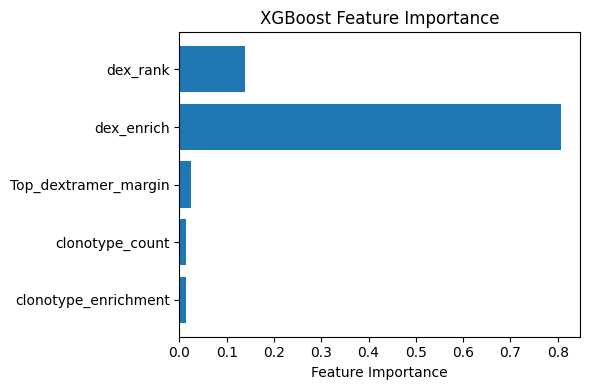

In [560]:
# Get importance scores
importance = xgb_model.feature_importances_
features = xgb_model.get_booster().feature_names

# Plot
plt.figure(figsize=(6, 4))
plt.barh(features, importance)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()